In [1]:
import os
from pathlib import Path
import re

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
path = Path('jigsaw-toxic-comment-classification-challenge')

if iskaggle:
    path = Path('../input/jigsaw-toxic-comment-classification-challenge')
    ! pip install -q datasets

In [2]:
!ls {path}

sample_submission.csv.zip  test.csv.zip  test_labels.csv.zip  train.csv.zip


## Preparando os dados

In [3]:
import pandas as pd
df = pd.read_csv(path/'train.csv.zip')

Visualizando o dataframe.

In [4]:
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


Como o meu objetivo é classificar um comentário apenas como tóxico ou não, eu crio uma nova label. 

In [5]:
label_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
df['labels'] = df[label_columns].apply(lambda x: sum(x), axis=1)
df['labels'] = df["labels"].apply(lambda x: 1 if x>=1 else 0)


    

Removendo as colunas desnecessárias.

In [6]:
df.drop(['id'], inplace=True, axis=1)
df.drop(label_columns, inplace=True, axis=1)

agora o dataframe é formado apenas por uma coluna de comentários e um label.

In [7]:
df.head()

,comment_text,labels
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


### Limpando o texto.

In [8]:
def clean_text(txt):
    return re.sub("[^A-Za-z0-9.,;:!?]+", ' ', str(txt))

In [9]:
df = df.rename(columns={"comment_text": "input"})
df['input'] = df["input"].apply(lambda x: clean_text(x))

In [10]:
df.head(10)

,input,labels
0,Explanation Why the edits made under my userna...,0
1,D aww! He matches this background colour I m s...,0
2,"Hey man, I m really not trying to edit war. It...",0
3,More I can t make any real suggestions on imp...,0
4,"You, sir, are my hero. Any chance you remember...",0
5,"Congratulations from me as well, use the tool...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word nonsense was offensive to yo...,0
9,alignment on this subject and which are contra...,0


Como podemos notar no gráfico abaixo, o número de comentários tóxicos do nosso treinamento é muito menor.

In [11]:
LABEL = df.columns.tolist()[1:]

In [12]:
toxicComment = df[df[LABEL].sum(axis=1) > 0]
okComment = df[df[LABEL].sum(axis=1) == 0]

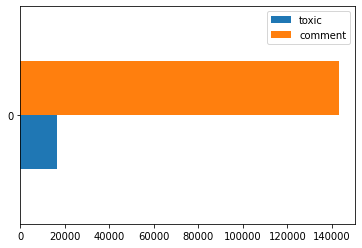

In [13]:
pd.DataFrame(dict(
  toxic=[len(toxicComment)],
  comment=[len(okComment)]
)).plot(kind='barh');

Vamos equilibrar a quantidade de comentários de cada categoria criando um novo dataframe contendo 1000 amostras de comentários tóxicos e 1000 de comentários não tóxicos.

In [14]:
new_df = pd.concat([
  toxicComment.sample(1000),
  okComment.sample(1000)
])

new_df = new_df.reset_index(drop=True)
new_df['labels'] = new_df['labels'].astype(float)

In [15]:
new_df

,input,labels
0,because stupid assumptions like your faggot go...,1.0
1,"CUM FOUNTAIN OF GIANT DICK, MAKE COMETSTYLES H...",1.0
2,Never Said That! I never said you criticised m...,1.0
3,"Singing is one thing, but you also need to sho...",1.0
4,"LOL, I got blocked by a bunch of sorry pedophi...",1.0
...,...,...
1995,Jos Eduardo dos Santos unknown to residents o...,0.0
1996,Thank you very much and you re making very goo...,0.0
1997,Autoblocked because your IP address was recen...,0.0
1998,Questions for the Wikipedia Signpost Hi! My na...,0.0


## Criando um dataset.

In [16]:
from datasets import Dataset,DatasetDict

ds = Dataset.from_pandas(new_df)

In [17]:
ds

Dataset({
    features: ['input', 'labels'],
    num_rows: 2000
})

## Gerando os tokens

In [18]:
model_nm = 'microsoft/deberta-v3-small'

In [19]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm, truncation=True)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/578 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.7/site-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [20]:
def tok_func(x): return tokz(x["input"])

In [21]:
tok_ds = ds.map(tok_func, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [22]:
row = tok_ds[0]
row['input'], row['input_ids']

('because stupid assumptions like your faggot goth ass makes doesn t account as a reliable source you stupid fuck. shut the hell up before i beat the shit out of you for fun you dumb nigger coon emo cunt',
 [1,
  401,
  5744,
  9898,
  334,
  290,
  57209,
  19474,
  424,
  474,
  283,
  268,
  682,
  702,
  1941,
  914,
  283,
  266,
  2899,
  1271,
  274,
  5744,
  25848,
  260,
  4234,
  262,
  4210,
  322,
  416,
  584,
  2584,
  262,
  17197,
  321,
  265,
  274,
  270,
  785,
  274,
  11502,
  2030,
  60394,
  1376,
  935,
  42313,
  84123,
  2])

In [23]:
tok_ds

Dataset({
    features: ['input', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2000
})

In [24]:
dds = tok_ds.train_test_split(0.20, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['input', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['input', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 400
    })
})

## Criando um set de validação.

In [25]:
eval_df = pd.read_csv(path/'test.csv.zip')
eval_df = eval_df[:2000]

In [26]:
eval_df = eval_df.rename(columns={"comment_text": "input"})
eval_df['input'] = eval_df["input"].apply(lambda x: clean_text(x))
eval_df.drop(['id'], inplace=True, axis=1)



In [27]:
eval_df

,input
0,Yo bitch Ja Rule is more succesful then you ll...
1,"From RfC The title is fine as it is, IMO."
2,Sources Zawe Ashton on Lapland
3,":If you have a look back at the source, the in..."
4,I don t anonymously edit articles at all.
...,...
1995,You crackers will never stop me! Just because ...
1996,Soraya Take a look at Soraya Post. Thanks.
1997,Wikipedia:Articles for deletion Geographic.or...
1998,:::It only means damn! or crap! again Which I...


In [28]:
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

## Treinando o modelo 

In [29]:
from transformers import TrainingArguments,Trainer

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [30]:
bs = 4
epochs = 5

In [31]:
lr = 8e-5

In [32]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')

In [33]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz)

Downloading:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [34]:
trainer.train();

The following columns in the training set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: input. If input are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1600
  Num Epochs = 5
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1000
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead

Epoch,Training Loss,Validation Loss
1,No log,0.072935
2,No log,0.153979
3,0.106100,0.085466
4,0.106100,0.087524
5,0.020400,0.088292


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: input. If input are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 400
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: input. If input are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 400
  Batch size = 16
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-500/special_tokens_map.j

In [35]:

preds = trainer.predict(eval_ds).predictions.astype(float)
preds

The following columns in the test set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: input. If input are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 16


array([[ 1.05273438],
       [-0.02798462],
       [-0.02861023],
       ...,
       [-0.03457642],
       [ 1.046875  ],
       [-0.02542114]])

In [36]:
import numpy as np
preds = np.clip(preds, 0, 1)

In [37]:
preds

array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [0.]])